In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf

In [2]:
import json
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer as NBA
from textblob.tokenizers import SentenceTokenizer as ST
from wordcloud import WordCloud, STOPWORDS
import string

In [3]:
#Data obtained from https://github.com/bpb27/trump_tweet_data_archive

In [4]:
def vectorize_letters(tweets):
    all_characters = ["{}".format(_) for tweet in tweets for _ in tweet]
    print("There are {} characters.".format(len(all_characters)))
    char_to_index = {u: i for i, u in enumerate(sorted(set(all_characters)))}

    vectorized = [[char_to_index[_] for _ in tweet] for tweet in tweets]
    return vectorized, char_to_index


In [5]:
def check_if_website(text):
    #Check for website:
    if text[:6] == "https:":
        website = True
    else:
        website = False
    return website


def remove_at_symbol(word):
    if word[0] == '@':
        return word[1:]
    else:
        return word


def separate_and_remove_special(text):
    text = "".join(
        [char for char in text if char not in ['“', '”', '(', ')'] and ord(char) < 128])
    #remove twitter's quotation characters.
    text_list = text.split(" ")
    #split the text into words to clean each word
    clean_string = []
    for word in text_list:
        if len(word) > 0:
            word = remove_at_symbol(word)
            website = check_if_website(word)
            if not website:
                clean_string.append(word)
    return " ".join(clean_string)


def parse_text(tweet):
    """
    Parse the message and only save it if it fits 
    the criteria:
        Not just a website link
    """
    website = check_if_website(tweet["text"])
    retweet = tweet["is_retweet"]
    #Remove the Retweet header if present
    if not website and not retweet:
        clean_string = separate_and_remove_special(tweet["text"])
        return clean_string
    else:
        return None

In [6]:
with open('condensed_2018.json') as f:
    tweets = json.load(f)
    print("There are {} tweets to parse.".format(len(tweets)))

There are 3510 tweets to parse.


In [7]:
clean_tweets = []
total_tweets = len(tweets)
for tweet in tweets:
    clean = parse_text(tweet)
    if clean != None:
        clean_tweets.append(clean)
print("There are {} usable tweets after removing {} \"bad\" tweets.".format(
    len(clean_tweets), total_tweets - len(clean_tweets)))

There are 2991 usable tweets after removing 519 "bad" tweets.


In [8]:
sentiment_list = []
nouns_list = []
verbs_list = []
adjectives_list = []
for clean in clean_tweets:
    tweet = TextBlob(clean, tokenizer=ST())
    for sub_tweet in tweet.tokens:
        sent = TextBlob(sub_tweet)
        for tag in sent.tags:
            if tag[1] in ["NN", "NNS", "NNP", "NNPS"]:
                nouns_list.append(tag[0])
                #nouns_list.append(tag[0].singularize())
        if not np.isclose(0.0, sent.sentiment[0]):
            sentiment_list.append([sent.sentiment[0], sent.sentiment[1]])
    #tweet = TextBlob(clean_tweets[i], analyzer=NaiveBayesAnalyzer())

In [9]:
sentiment_list = np.array(sentiment_list)

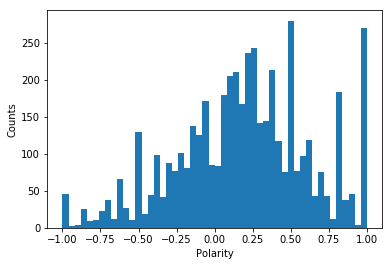

In [10]:
fig, ax = plt.subplots()
hist = ax.hist(sentiment_list[:, 0], bins=50)
txt = ax.set_xlabel("Polarity")
txt = ax.set_ylabel("Counts")
#hist = ax.hist(sentiment_list[:,1], bins = 30, alpha = 0.5)

In [11]:
def generate_cloud_mask():
    trump_mask = np.array(Image.open("trump_mask.png"))
    trump_mask[trump_mask >= 1] = 255
    trump_mask[trump_mask < 1] = 0.
    trump_mask = trump_mask * -1
    trump_mask = trump_mask + 255
    return trump_mask

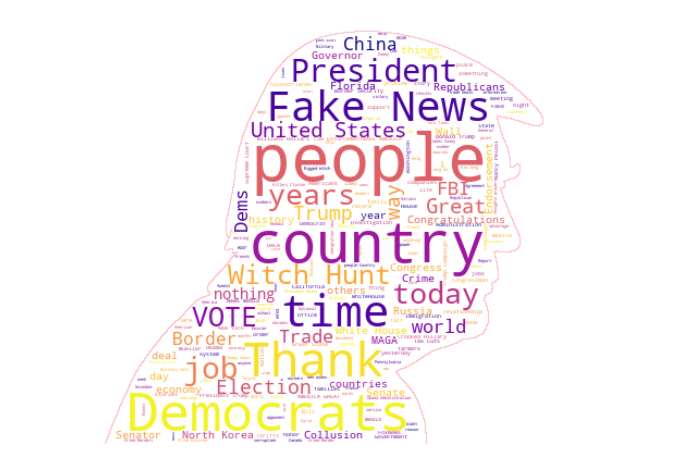

In [12]:
trump_mask = generate_cloud_mask()
ratio = trump_mask
mask_ratio = trump_mask.shape[1]/trump_mask.shape[0]
stopwords = set(STOPWORDS)
stopwords.add("amp")
wc = WordCloud(
    background_color="white",
    max_words=1000,
    mask=trump_mask,
    stopwords=stopwords,
    contour_width=0.01,
    contour_color="pink",
    colormap='plasma',
    #colormap = 'RdBu',
    normalize_plurals=False,
)
wc.generate(" ".join(nouns_list))
figsize = 8
fig, ax = plt.subplots(figsize=(figsize*mask_ratio, figsize))
ax.imshow(wc, interpolation='bilinear')
p = plt.axis("off")
plt.savefig("trump.png", bbox_inches="tight")

In [13]:
class Markov_Text_Prediction:
    def __init__(self, tweets):
        self.tweets = tweets
        
    def run(self):
        self.tweet_combiner()
        self.generate_dict()
        pairs = self.make_pairs()
        for w1, w2, in pairs:
            if w1 in self.word_dict.keys():
                self.word_dict[w1].append(w2)
            else:
                self.word_dict[w1] = [w2]
        
    def tweet_combiner(self):
        self.corpus = " ".join(self.tweets).split()
        
    def make_pairs(self):
        for i in range(1, len(self.corpus)-1):
            yield (self.corpus[i], self.corpus[i+1])
        
    def generate_dict(self):
        s = [(self.corpus[0], [self.corpus[1]])]
        self.word_dict = defaultdict(list)
        for k, v in s:
            self.word_dict[k].append(v)
            
    def check_start(self, sentence_start):
        capitalized = sentence_start[0].isupper()
        non_punctuation = sentence_start[-1] not in string.punctuation
        if capitalized and non_punctuation:
            return True
        else:
            return False
        
    def get_next_word(self, tweet, tolerance, min_occurances):
        iterations = 0
        keep = False
        while not keep:
            proposed_word = np.random.choice(self.word_dict[tweet[-1]])
            possibilities = len(self.word_dict[tweet[-1]])
            occurances = self.word_dict[tweet[-1]].count(proposed_word)
            if occurances/possibilities > tolerance or occurances > min_occurances:
                keep = True
            iterations += 1
            if iterations > 100:
                break
        return proposed_word
        
    def predict(self, max_words = 30, tolerance = 0.05, min_occurances=10):
        counter = 0
        sentence_start = np.random.choice(self.corpus)
        while self.check_start(sentence_start) == False:
            sentence_start = np.random.choice(self.corpus)
            
        tweet = [sentence_start]
        for _ in range(1, max_words+100):
            tweet.append(self.get_next_word(tweet, tolerance, min_occurances))
            if tweet[-1][-1] in [".", "!", "?"]:
                frac = _/max_words
                if np.random.random() < frac:
                    break
        print(" ".join(tweet))

In [14]:
chain = Markov_Text_Prediction(clean_tweets)
chain.run()

In [15]:
chain.predict(tolerance = 0.05, min_occurances = 10)

Now that we need a great honor to keep our country and are working with the World Wars One way to the State of the FBI &amp; the State of the Fake News Media has my total Endorsement!


The Markov Chain doesn't work super well. Let's try a recurrent neural network.

In [16]:
vectorized, char_to_index = vectorize_letters(clean_tweets)
index_to_char = {v: k for k, v in char_to_index.items()}
print(vectorized[0], "--->",
      "".join([index_to_char[_] for _ in vectorized[0]]))

There are 578100 characters.
[37, 30, 45, 45, 54, 1, 43, 34, 52, 1, 54, 34, 30, 47, 2] ---> HAPPY NEW YEAR!


In [25]:
class Neural_Net:
    def __init__(self, vectorized):
        self.vectorized = vectorized
        self.in_length = 20
        self.batch_size = 1000
        self.rnn_size = 128
        self.out_size = len(np.unique(self.vectorized))

    def make_array(self):
        vectorized = np.array([i for x in self.vectorized for i in x])
        self.vectorized = vectorized.flatten()

    def create_batch(self):
        size = self.batch_size
        array = self.vectorized
        batch = []
        ys = []
        starts = np.random.randint(len(array), size=size)
        for start in starts:
            if self.in_length + start > len(array):
                datum = np.hstack(
                    (array[start:],
                     array[:(self.in_length + start) % len(array)]))
            else:
                datum = array[start:start + self.in_length]
            y = array[(start + self.in_length + 1) % len(array)]
            encoded = np.zeros(self.out_size)
            encoded[int(y)] = 1
            ys.append(encoded)
            batch.append(np.array([datum]))
        ys = np.array(ys)
        batch = np.array(batch, dtype=np.float32)
        return batch, ys

    def add_layer(self, x, W, b):
        return tf.add(tf.matmul(x, W), b)

    def recurrent_nn(self, layer):
        x, y = self.create_batch()
        print(x.shape)
        #x = tf.reshape(x, [-1, self.out_size])
        #x = tf.split(x, self.in_length, 0)
        #x = tf.reshape(x, [-1, self.in_length])
        #x = tf.split(x, self.batch_size, 0)
        rnn_cell = tf.keras.layers.StackedRNNCells([
            tf.keras.layers.LSTM(self.rnn_size, dtype=tf.float32),
            tf.keras.layers.LSTM(self.rnn_size, dtype=tf.float32)
        ])
        outputs, states = tf.keras.layers.RNN(rnn_cell, x, dtype=tf.float32, unroll=True)
        #outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        output = tf.add(
            tf.matmul(outputs[-1], layer['weights']), layer['biases'])

        return output, y

    def run(self, epochs):
        tf.reset_default_graph()
        self.make_array()

        layer = {
            'weights':
            tf.Variable(
                tf.random_normal(shape=[self.rnn_size, self.out_size])),
            'biases':
            tf.Variable(tf.random_normal(shape=[self.out_size]))
        }

        x = tf.placeholder(
            tf.int8, shape=[None, self.in_length, self.out_size])
        y = tf.placeholder(tf.int8, [None,self.out_size])

        pred, y_ = self.recurrent_nn(layer)
        print(pred.shape, y_.shape)
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_))
        optimizer = tf.train.AdamOptimizer().minimize(cost)

        print("Starting Session")

        with tf.Session() as sess:
            for epoch in epochs:
                print(epoch)
                epoch_loss = 0

                _, c = sess.run([optimize, cost], feed_dict={x: x, y: y_})

            print("Finished")
            correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            print(accuracy.eval({x: x, y: y}))

In [26]:
the_donald = Neural_Net(vectorized)
the_donald.run(1)

(1000, 1, 20)


ValueError: ('All cells must have a `state_size` attribute. received cells:', [<tensorflow.python.keras.layers.recurrent.LSTM object at 0x7f66ed135c50>, <tensorflow.python.keras.layers.recurrent.LSTM object at 0x7f66ed14c668>])

In [ ]:
print(batch[0], ys[0])